# Imports

In [65]:
# Importing Libraries

In [66]:
!pip install json-tricks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
#from pydub import AudioSegment, effects
#import noisereduce as nr


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio

import tensorflow as tf
import keras
import sklearn


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical, plot_model


from keras.models import Sequential, model_from_json, load_model
from keras import layers
from keras import optimizers
from keras import callbacks

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.multiclass import OneVsRestClassifier


from tqdm import tqdm


from json_tricks import dump, load



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import time
tic = time.perf_counter()



# Dataset

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
#Crema = "/content/drive/MyDrive/datasets/speech/CREMAD/sample/"
#Crema = "/content/drive/MyDrive/datasets/speech/CREMAD/AudioWAV/"
Ravdess = "/content/drive/MyDrive/datasets/speech/RAVDESS/data/Audio_Speech_Actors_01-24"
Ravdess_processed = "/content/drive/MyDrive/datasets/speech/RAVDESS/processedData/onlySpeech/"
Ravdess_speech_sample = "/content/drive/MyDrive/datasets/speech/RAVDESS/data/Audio_Speech_Actors_01-24/"
df_path = "/content/drive/MyDrive/datasets/speech/RAVDESS/ravdess_df_onlySpeech.csv"
model_path = Ravdess + "/model/"

checkpoint_path = model_path + "best_weights-os-LSTM-1.hdf5"
saved_model_path = model_path + 'model8723-os-LSTM-1.json'

saved_weights_path = model_path + 'model8723_weights-os-LSTM-1.h5'
saved_model_path_2 = model_path + 'Speech-Emotion-Recognition-Model-os-LSTM-1.h5'

In [70]:
##Hypter Parameters' Range
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}
#TIME_STEPS = params["time_steps"]
#BATCH_SIZE = params["batch_size"]
#iter_changes = "dropout_layers_0.4_0.4"


# Load Processed Files, Construct Train, Validation and Test Sets

In [71]:

processed_path = Ravdess_processed
x_path = processed_path + "X_features.json" # FILE LOAD PATH
y_path =  processed_path + "Y_labels.json" # FILE SAVE PATH
#x_path = '/content/drive/MyDrive/datasets/speech/RAVDESS/processedData/X_features.json'

# Load X,Y json files back into lists, convert to np.arrays

X = load(x_path)
X = np.asarray(X, dtype = 'float32')

Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [72]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
# 1st Split: X,Y => (x_train, x_tosplit) (y_train, y_tosplit)
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
# 2nd Split: x_tosplit,y_tosplit => (x_val, x_test) (y_val, y_test) 
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)
#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 7, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 7, dtype = 'int8')

In [73]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(1176, 448, 15)
(116, 448, 15)
(52, 448, 15)


In [74]:
# Save x_test, y_test to JSON.

x_test_path = processed_path + 'x_test_data.json'
dump(obj = x_test, fp = x_test_path)

y_test_path = processed_path + 'y_test_data.json'
dump(obj = y_test, fp = y_test_path)

'{"__ndarray__": [[0], [2], [6], [5], [3], [3], [2], [4], [4], [3], [6], [2], [0], [5], [0], [5], [0], [0], [6], [3], [5], [3], [3], [3], [4], [2], [5], [5], [2], [1], [4], [2], [6], [3], [2], [4], [0], [0], [3], [4], [6], [1], [0], [3], [2], [0], [5], [2], [4], [5], [0], [5]], "dtype": "int8", "shape": [52, 1], "Corder": true}'

In [75]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load(processed_path + 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load(processed_path + 'y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 7, dtype = 'int8')

In [76]:
X.shape

(1344, 448, 15)

In [77]:
X.shape[1:3]

(448, 15)

# RNN Model

In [81]:
tic

4829.511644707

## Define Model & Training

In [82]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(128, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(7, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions

#-> EearlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                    patience=10, min_delta=0.0001)


#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=20)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 448, 128)          73728     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 123,591
Trainable params: 123,591
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
history = model.fit(x_train, y_train_class, 
                      epochs=340, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [es, mcp_save, rlrop])
toc = time.perf_counter()

Epoch 1/340
52/52 [==============================] - 57s 948ms/step - loss: 1.9707 - categorical_accuracy: 0.1412 - val_loss: 1.9710 - val_categorical_accuracy: 0.1121 - lr: 0.0010
Epoch 2/340
52/52 [==============================] - 55s 1s/step - loss: 1.9486 - categorical_accuracy: 0.1658 - val_loss: 1.9089 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/340
52/52 [==============================] - 47s 913ms/step - loss: 1.9318 - categorical_accuracy: 0.1675 - val_loss: 1.9323 - val_categorical_accuracy: 0.1121 - lr: 0.0010
Epoch 4/340
52/52 [==============================] - 49s 935ms/step - loss: 1.9225 - categorical_accuracy: 0.1862 - val_loss: 1.9017 - val_categorical_accuracy: 0.2328 - lr: 0.0010
Epoch 5/340
52/52 [==============================] - 47s 909ms/step - loss: 1.9285 - categorical_accuracy: 0.1862 - val_loss: 1.9671 - val_categorical_accuracy: 0.1293 - lr: 0.0010
Epoch 6/340
52/52 [==============================] - 49s 934ms/step - loss: 1.9286 - categorical_a

In [84]:
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 23.8539 minutes


## Loading Model

In [85]:
# Define the best weights to the model.\
#model.load_weights(checkpoint_path)

# Evaluation

## Save & Load model, weights

In [86]:
# Saving model & weights
model_json = model.to_json()



with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


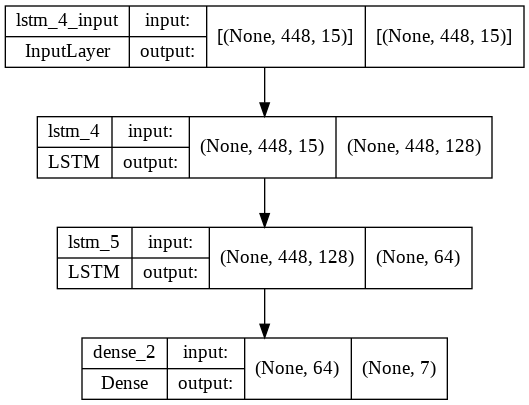

In [87]:
# Reading the model from JSON file
#model_path = Ravdess + "/model/"
#saved_model_path = model_path + 'model8723.json'
#saved_weights_path = model_path + 'model8723_weights.h5'


with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [88]:
model.save(saved_model_path_2)

## Train (fit) Visualization

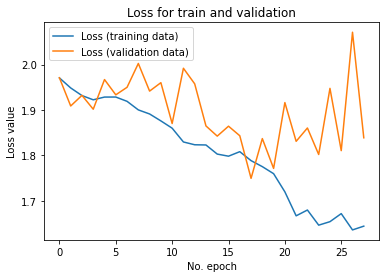

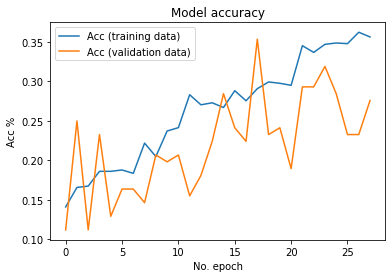

In [89]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Validation Set Evaluation

### Val Set Score

In [90]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)


4/4 - 3s - loss: 1.8389 - categorical_accuracy: 0.2759 - 3s/epoch - 731ms/step


### Construct Predicted Labels based on Probability of each class

In [91]:
y_val_class

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0,

In [92]:
np.argmax(y_val_class, axis=1)

array([0, 1, 6, 1, 5, 1, 4, 6, 6, 1, 2, 4, 6, 5, 6, 3, 2, 2, 0, 6, 1, 6,
       5, 0, 4, 5, 0, 3, 1, 3, 6, 5, 0, 3, 0, 5, 2, 6, 2, 4, 4, 3, 5, 4,
       2, 3, 2, 4, 3, 2, 6, 6, 1, 5, 0, 4, 2, 4, 5, 5, 2, 2, 6, 1, 6, 4,
       4, 6, 2, 0, 5, 0, 3, 2, 6, 3, 3, 6, 5, 5, 1, 1, 1, 5, 6, 6, 1, 2,
       0, 6, 3, 3, 6, 6, 2, 3, 0, 6, 3, 2, 6, 0, 0, 5, 3, 6, 6, 4, 1, 3,
       5, 5, 3, 4, 4, 2])

In [93]:
y_val_class = np.argmax(y_val_class, axis=1)
predictions_val = model.predict(x_val)
y_proba_val_class = predictions_val
y_pred_val_class = np.argmax(predictions_val, axis=1)

In [94]:
predictions_val


array([[0.12925228, 0.22544794, 0.1394083 , 0.02442103, 0.28513947,
        0.05952077, 0.13681029],
       [0.00894064, 0.07732225, 0.05656806, 0.46640217, 0.06557158,
        0.22231105, 0.10288424],
       [0.00577196, 0.09761997, 0.04004664, 0.51963913, 0.08846302,
        0.1316014 , 0.11685794],
       [0.02040852, 0.05747191, 0.09135529, 0.2260705 , 0.04502047,
        0.40677404, 0.15289927],
       [0.00408252, 0.06852844, 0.03032917, 0.618679  , 0.05980092,
        0.12651332, 0.09206662],
       [0.01253996, 0.18782456, 0.07185014, 0.15670234, 0.22483519,
        0.08614572, 0.26010206],
       [0.03143587, 0.19441873, 0.07053295, 0.02716126, 0.5211848 ,
        0.01680766, 0.13845876],
       [0.02133104, 0.05957903, 0.09179918, 0.22891253, 0.04705245,
        0.40122443, 0.15010132],
       [0.00566994, 0.14249948, 0.06341809, 0.15043008, 0.35579652,
        0.05074409, 0.23144181],
       [0.3184034 , 0.11853617, 0.14994358, 0.00631928, 0.32095492,
        0.02033986, 0.0

In [95]:
y_pred_val_class 

array([4, 3, 3, 5, 3, 6, 4, 5, 4, 4, 0, 6, 3, 4, 5, 4, 6, 0, 0, 5, 1, 3,
       3, 0, 1, 6, 5, 3, 0, 1, 5, 3, 5, 3, 1, 3, 5, 4, 4, 0, 4, 1, 3, 5,
       3, 3, 4, 1, 6, 0, 4, 1, 0, 0, 5, 4, 4, 4, 1, 3, 3, 6, 3, 3, 4, 0,
       1, 4, 6, 3, 5, 0, 3, 1, 4, 3, 3, 1, 0, 1, 1, 6, 6, 3, 3, 0, 6, 4,
       0, 4, 3, 3, 6, 3, 5, 3, 0, 1, 3, 3, 6, 0, 1, 5, 3, 6, 4, 1, 2, 3,
       5, 5, 4, 1, 4, 4])

### Val Set Confusion Matrix and Heatmap

Text(0.5, 51.0, 'Predicted emotion')

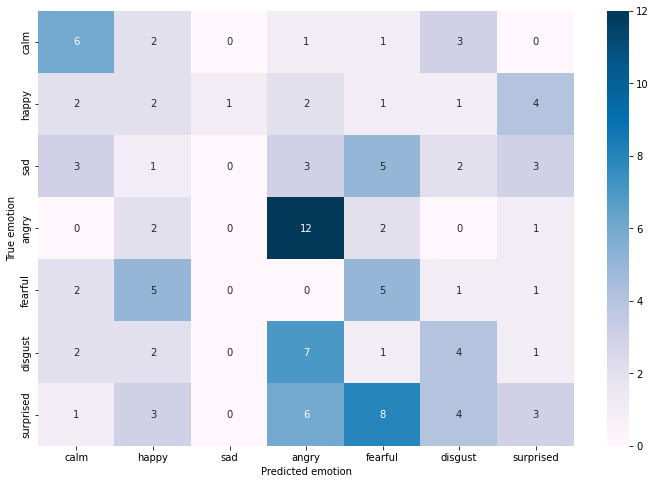

In [96]:
# Validation Confusion matrix
cm=confusion_matrix(y_val_class, y_pred_val_class)

index = ['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [97]:
# Confusion Matrix
cm

array([[ 6,  2,  0,  1,  1,  3,  0],
       [ 2,  2,  1,  2,  1,  1,  4],
       [ 3,  1,  0,  3,  5,  2,  3],
       [ 0,  2,  0, 12,  2,  0,  1],
       [ 2,  5,  0,  0,  5,  1,  1],
       [ 2,  2,  0,  7,  1,  4,  1],
       [ 1,  3,  0,  6,  8,  4,  3]])

### Validation Set Predicted emotions accuracy

In [98]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
calm : 0.4615
happy : 0.1538
sad : 0.0000
angry : 0.7059
fearful : 0.3571
disgust : 0.2353
surprised : 0.1200


### Precision, Recal, Fscore

In [99]:
# Validation set precision, recall, fscore

precision_recall_fscore_support(y_val_class, y_pred_val_class, average='macro')


(0.2277958621144002, 0.2905291347308155, 0.24647020627056923, None)

In [100]:
precision_recall_fscore_support(y_val_class, y_pred_val_class, average='weighted')

(0.22699223525370582, 0.27586206896551724, 0.23787755071549427, None)

## Test Set Evaluation

### Test Set Score



In [101]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

2/2 - 0s - loss: 1.6031 - categorical_accuracy: 0.4423 - 451ms/epoch - 225ms/step


### Construct Predicted Labels based on Probability of each class

In [102]:
y_test_class

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0,

In [103]:
 np.argmax(y_test_class, axis=1)

array([0, 2, 6, 5, 3, 3, 2, 4, 4, 3, 6, 2, 0, 5, 0, 5, 0, 0, 6, 3, 5, 3,
       3, 3, 4, 2, 5, 5, 2, 1, 4, 2, 6, 3, 2, 4, 0, 0, 3, 4, 6, 1, 0, 3,
       2, 0, 5, 2, 4, 5, 0, 5])

In [104]:
y_test_class = np.argmax(y_test_class, axis=1)
predictions_test = model.predict(x_test)
y_pred_test_class = np.argmax(predictions_test, axis=1)
y_proba_test_class = predictions_test



In [105]:
predictions_test

array([[0.49862877, 0.10612305, 0.16914816, 0.00702601, 0.10141182,
        0.05285146, 0.06481074],
       [0.16014448, 0.16236776, 0.19972439, 0.03369904, 0.11745483,
        0.14009517, 0.18651444],
       [0.01066395, 0.1613409 , 0.0609362 , 0.25989053, 0.15899786,
        0.12358721, 0.22458339],
       [0.04492865, 0.25354946, 0.11359753, 0.17406902, 0.14628564,
        0.17325024, 0.09431943],
       [0.00248328, 0.0329175 , 0.02097396, 0.7781739 , 0.0242585 ,
        0.10113098, 0.04006191],
       [0.00806128, 0.04830614, 0.05164465, 0.5239117 , 0.0396555 ,
        0.2630595 , 0.06536126],
       [0.5453969 , 0.09487832, 0.1943671 , 0.0068395 , 0.06363415,
        0.05385374, 0.04103021],
       [0.03302519, 0.08313721, 0.10968828, 0.16351989, 0.06381471,
        0.35117775, 0.19563702],
       [0.00592476, 0.10937056, 0.04538153, 0.36351755, 0.11720362,
        0.1410902 , 0.2175118 ],
       [0.01841839, 0.17675772, 0.07360366, 0.13894387, 0.26151815,
        0.08411534, 0.2

In [106]:
y_pred_test_class 

array([0, 2, 3, 1, 3, 3, 0, 5, 3, 4, 6, 1, 0, 6, 5, 5, 0, 0, 3, 3, 0, 4,
       3, 3, 1, 3, 5, 3, 6, 1, 4, 0, 3, 3, 0, 1, 0, 1, 5, 4, 1, 6, 0, 3,
       4, 3, 3, 1, 0, 5, 0, 5])

### Test Set Confusion Matrix and Heatmap

Text(0.5, 51.0, 'Predicted emotion')

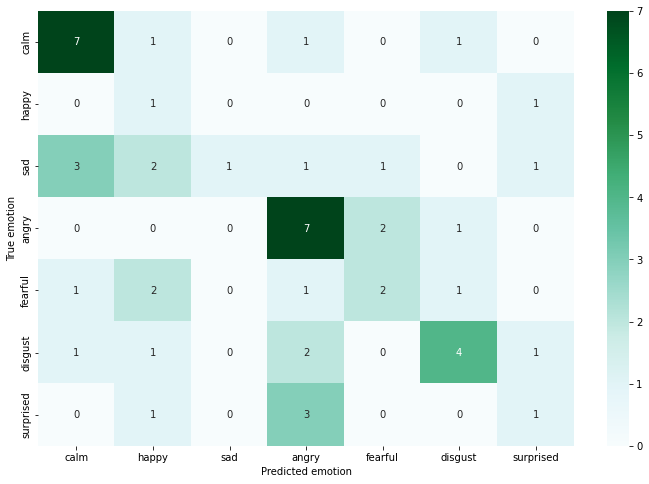

In [107]:
# Test set Confusion matrix

cm=confusion_matrix(y_test_class, y_pred_test_class)

index = ['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [108]:
# Confusion Matrix
cm

array([[7, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [3, 2, 1, 1, 1, 0, 1],
       [0, 0, 0, 7, 2, 1, 0],
       [1, 2, 0, 1, 2, 1, 0],
       [1, 1, 0, 2, 0, 4, 1],
       [0, 1, 0, 3, 0, 0, 1]])

### Test Set Predicted emotions accuracy

In [109]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
calm : 0.7000
happy : 0.5000
sad : 0.1111
angry : 0.7000
fearful : 0.2857
disgust : 0.4444
surprised : 0.2000


### Precision, Recal, Fscore

In [110]:
# Validation set precision, recall, fscore

precision_recall_fscore_support(y_test_class, y_pred_test_class, average='macro')


(0.48520408163265305, 0.42018140589569164, 0.3788455988455989, None)

In [111]:
precision_recall_fscore_support(y_test_class, y_pred_test_class, average='weighted')

(0.5565934065934066, 0.4423076923076923, 0.4251554001554002, None)

### ROC AUC Score

In [112]:
ravdess_df = pd.read_csv (df_path)

In [113]:
labels = ["calm", "happy", "sad", "angry", "fear", "disgust", "suprised"]

In [114]:
y_test_adj = y_test.reshape(-1,)

In [115]:
y_proba_test_class.shape

(52, 7)

In [116]:
y_test.shape

(52, 1)

In [117]:
y_test_adj

array([0, 2, 6, 5, 3, 3, 2, 4, 4, 3, 6, 2, 0, 5, 0, 5, 0, 0, 6, 3, 5, 3,
       3, 3, 4, 2, 5, 5, 2, 1, 4, 2, 6, 3, 2, 4, 0, 0, 3, 4, 6, 1, 0, 3,
       2, 0, 5, 2, 4, 5, 0, 5], dtype=int8)

In [118]:


macro_roc_auc_ovo = roc_auc_score(y_test_adj, y_proba_test_class, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test_adj, y_proba_test_class, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test_adj, y_proba_test_class, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test_adj, y_proba_test_class, multi_class="ovr", average="weighted"
)


In [119]:
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} " "(weighted by prevalence)\n".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} " "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.749812 (macro),
0.753007 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.761574 (macro),
0.752480 (weighted by prevalence)
